<a href="https://colab.research.google.com/github/Jhoe73/data_science/blob/main/LSTM_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [177]:
# from google.colab import drive
# drive.mount('/content/drive')

In [178]:
# Carregar o dataset
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_science/SPX.csv')
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

df = pd.read_csv('/content/SPX.csv', index_col='Date', parse_dates=True)

In [179]:
# Limitar o DataFrame
df = df.iloc[17000:23000]

In [180]:
df.head

<bound method NDFrame.head of                    Open         High          Low        Close    Adj Close  \
Date                                                                          
1995-09-26   581.809998   584.659973   580.650024   581.409973   581.409973   
1995-09-27   581.409973   581.419983   574.679993   581.039978   581.039978   
1995-09-28   581.039978   585.880005   580.690002   585.869995   585.869995   
1995-09-29   585.869995   587.609985   584.000000   584.409973   584.409973   
1995-10-02   584.409973   585.049988   580.539978   581.719971   581.719971   
...                 ...          ...          ...          ...          ...   
2019-07-22  2981.929932  2990.709961  2976.649902  2985.030029  2985.030029   
2019-07-23  2994.739990  3005.899902  2988.560059  3005.469971  3005.469971   
2019-07-24  2998.770020  3019.590088  2996.820068  3019.560059  3019.560059   
2019-07-25  3016.260010  3016.310059  2997.239990  3003.669922  3003.669922   
2019-07-26  3013.25000

<Axes: xlabel='Date'>

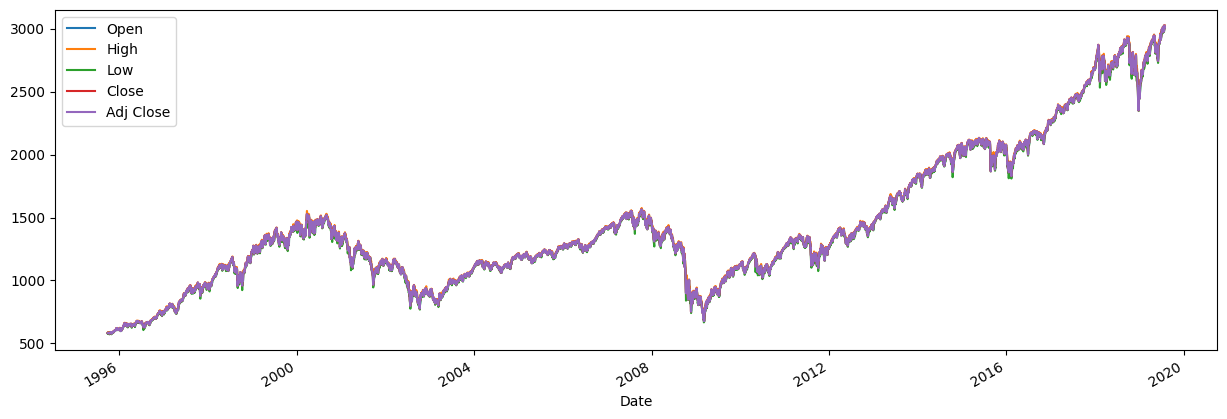

In [181]:
df_drop_volume = df.drop(columns=['Volume'])
df_drop_volume.plot(figsize = (15,5))

<Axes: xlabel='Date'>

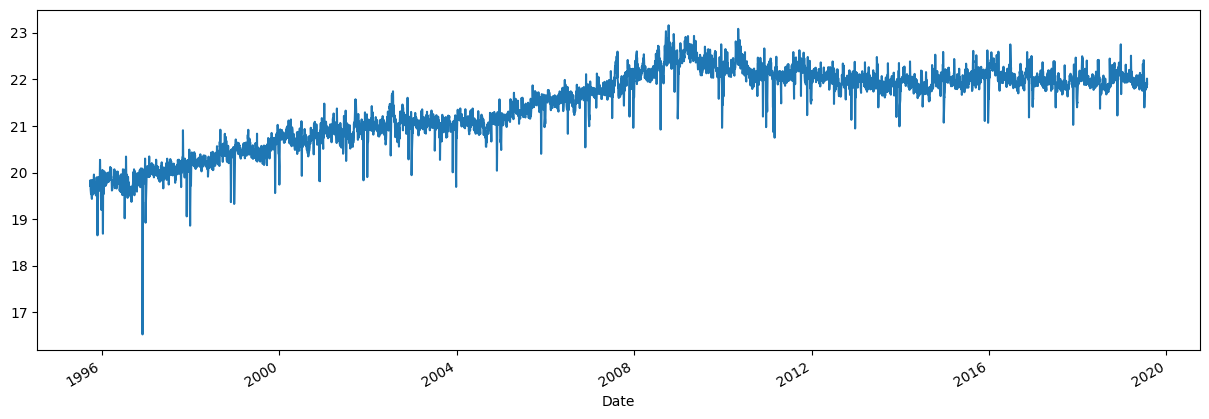

In [182]:
# Somente a coluna volume (data é index)
df_volume = df[['Volume']]

# Volume com escala logarítmica
df_volume = np.log(df_volume['Volume'])
df_volume.plot(figsize = (15,5))

In [183]:
df_volume.head

<bound method NDFrame.head of Date
1995-09-26    19.711647
1995-09-27    19.834833
1995-09-28    19.722832
1995-09-29    19.630387
1995-10-02    19.535790
                ...    
2019-07-22    21.823117
2019-07-23    21.921319
2019-07-24    21.955529
2019-07-25    22.016696
2019-07-26    21.904253
Name: Volume, Length: 6000, dtype: float64>

<Axes: xlabel='Volume', ylabel='Count'>

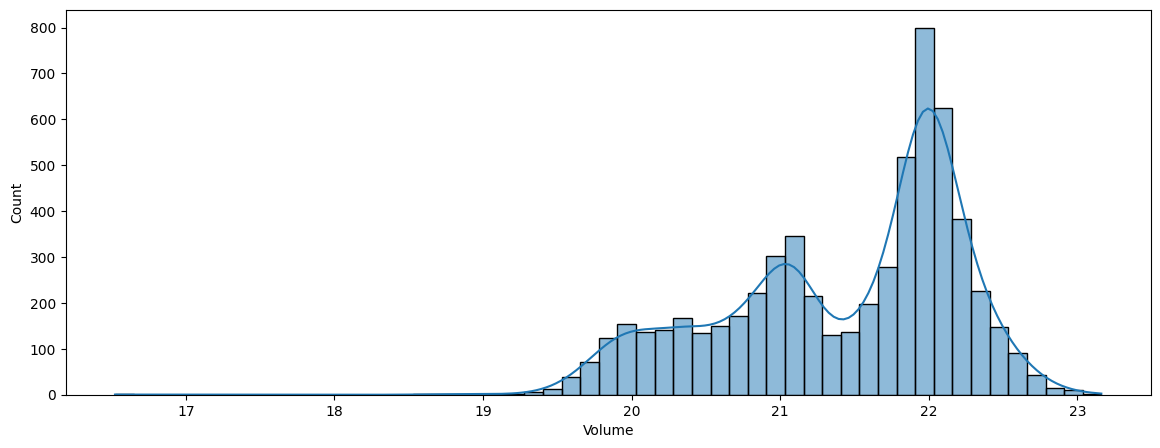

In [184]:
plt.figure(figsize = (14,5))
sns.histplot(df_volume, kde=True)

<Axes: xlabel='Date'>

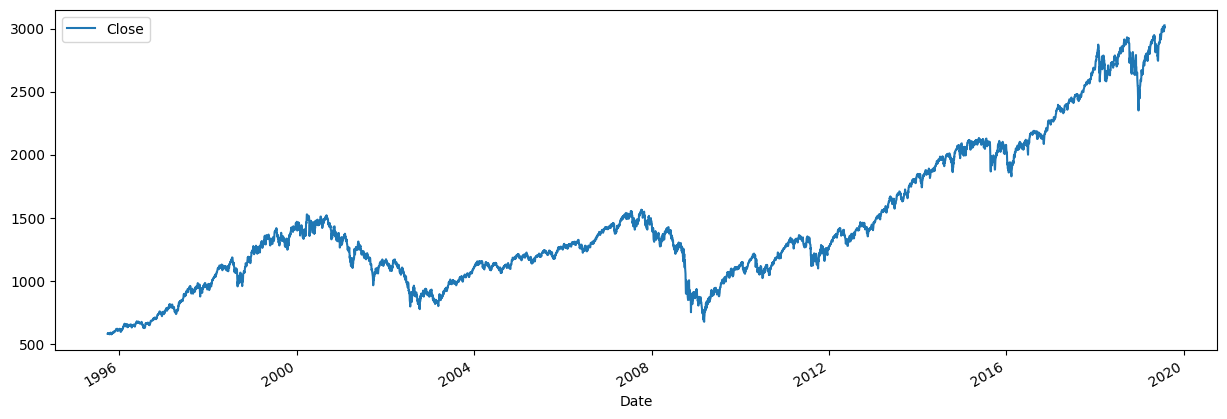

In [185]:
df_close = df[['Close']]
df_close.plot(figsize = (15,5))

In [186]:
df_close.head

<bound method NDFrame.head of                   Close
Date                   
1995-09-26   581.409973
1995-09-27   581.039978
1995-09-28   585.869995
1995-09-29   584.409973
1995-10-02   581.719971
...                 ...
2019-07-22  2985.030029
2019-07-23  3005.469971
2019-07-24  3019.560059
2019-07-25  3003.669922
2019-07-26  3025.860107

[6000 rows x 1 columns]>

<Axes: ylabel='Count'>

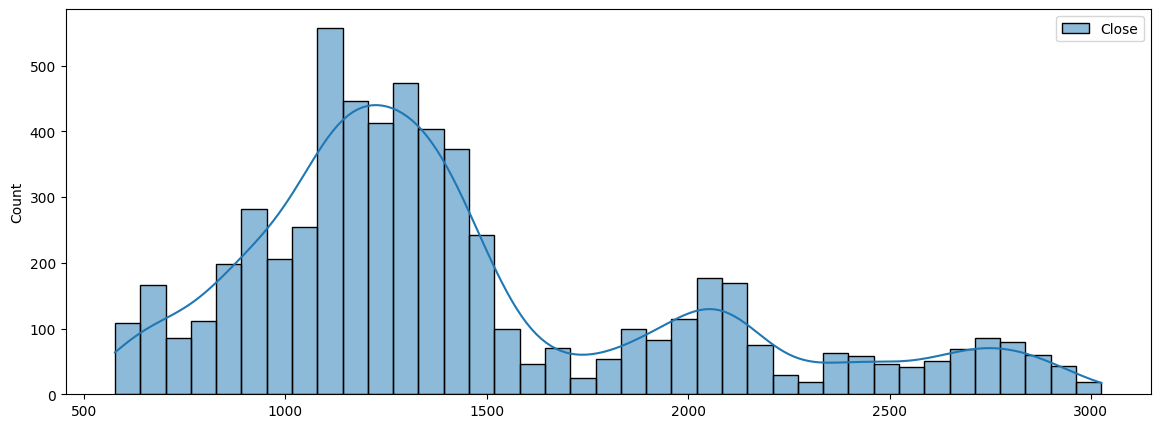

In [187]:
plt.figure(figsize = (14,5))
sns.histplot(df_close, kde=True)

In [188]:
df_ori = df
df = df.drop(columns=['Adj Close', 'Volume'])
df

,Open,High,Low,Close
Date,,,,
1995-09-26,581.809998,584.659973,580.650024,581.409973
1995-09-27,581.409973,581.419983,574.679993,581.039978
1995-09-28,581.039978,585.880005,580.690002,585.869995
1995-09-29,585.869995,587.609985,584.000000,584.409973
1995-10-02,584.409973,585.049988,580.539978,581.719971
...,...,...,...,...
2019-07-22,2981.929932,2990.709961,2976.649902,2985.030029
2019-07-23,2994.739990,3005.899902,2988.560059,3005.469971
2019-07-24,2998.770020,3019.590088,2996.820068,3019.560059


In [189]:
# Normalizar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

In [190]:
scaled_data

array([[0.00208515, 0.00256775, 0.00372793, 0.00191496],
       [0.00192128, 0.00124509, 0.00128224, 0.00176389],
       [0.00176971, 0.0030658 , 0.00374431, 0.00373601],
       ...,
       [0.99220426, 0.99657501, 0.99353963, 0.99742765],
       [0.99936912, 0.99523601, 0.99371166, 0.9909396 ],
       [0.99813605, 1.        , 1.        , 1.        ]])

In [191]:
# Definindo o número de timesteps
n_timesteps = 10  # por exemplo, usar 10 dias anteriores para prever o próximo

In [192]:
# Preparar os dados para o LSTM
def create_dataset(data, n_timesteps=1):
    X, y = [], []
    for i in range(len(data)-n_timesteps-1):
        a = data[i:(i+n_timesteps), :-1]   # todas as colunas exceto a última
        X.append(a)
        y.append(data[i + n_timesteps, -1]) # última coluna
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, n_timesteps)

In [193]:
y[:2], y.shape

(array([0.00032667, 0.00111878]), (5989,))

In [194]:
X[:2], X.shape

(array([[[0.00208515, 0.00256775, 0.00372793],
         [0.00192128, 0.00124509, 0.00128224],
         [0.00176971, 0.0030658 , 0.00374431],
         [0.00374835, 0.00377202, 0.00510029],
         [0.00315025, 0.00272696, 0.00368285],
         [0.00204827, 0.00162068, 0.00283895],
         [0.00230228, 0.00162068, 0.00342476],
         [0.00194586, 0.00173906, 0.00328959],
         [0.00242107, 0.00251876, 0.00432192],
         [0.00236372, 0.0016819 , 0.00196637]],
 
        [[0.00192128, 0.00124509, 0.00128224],
         [0.00176971, 0.0030658 , 0.00374431],
         [0.00374835, 0.00377202, 0.00510029],
         [0.00315025, 0.00272696, 0.00368285],
         [0.00204827, 0.00162068, 0.00283895],
         [0.00230228, 0.00162068, 0.00342476],
         [0.00194586, 0.00173906, 0.00328959],
         [0.00242107, 0.00251876, 0.00432192],
         [0.00236372, 0.0016819 , 0.00196637],
         [0.00067594, 0.        , 0.        ]]]),
 (5989, 10, 3))

In [195]:
# Dividir em conjuntos de treino e teste
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [196]:
# Definir a arquitetura do autoencoder
timesteps = n_timesteps
features = X.shape[2]

In [197]:
# Construir o modelo LSTM com Autoencoders Empilhados
model = Sequential()

# Primeira camada LSTM
model.add(LSTM(100, input_shape=(timesteps, features), return_sequences=True))

# teste (remover depois)
# model.add(LSTM(50, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

# Autoencoder
# model.add(LSTM(100, activation='relu', return_sequences=False))
# model.add(RepeatVector(n_timesteps))
# model.add(LSTM(100, activation='relu', return_sequences=True))

# Camada de saída
# model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 10, 100)           41600     
                                                                 
 lstm_28 (LSTM)              (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 122101 (476.96 KB)
Trainable params: 122101 (476.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [198]:
# it stops the model training once it realizes that there will be no more decrease in loss in further epochs
early_stop = EarlyStopping(monitor='val_loss', patience = 5)

model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer=Adam(learning_rate = 0.0001)', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks = [early_stop])

Epoch 1/10
126/126 [==============================] - 5s 12ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 2/10
126/126 [==============================] - 1s 7ms/step - loss: 1.1783e-04 - val_loss: 0.0011
Epoch 3/10
126/126 [==============================] - 1s 7ms/step - loss: 1.1720e-04 - val_loss: 0.0011
Epoch 4/10
126/126 [==============================] - 1s 8ms/step - loss: 1.1519e-04 - val_loss: 6.9102e-04
Epoch 5/10
126/126 [==============================] - 1s 7ms/step - loss: 1.1844e-04 - val_loss: 3.4937e-04
Epoch 6/10
126/126 [==============================] - 1s 7ms/step - loss: 1.1612e-04 - val_loss: 4.8351e-04
Epoch 7/10
126/126 [==============================] - 1s 8ms/step - loss: 1.1102e-04 - val_loss: 4.6129e-04
Epoch 8/10
126/126 [==============================] - 1s 8ms/step - loss: 1.0265e-04 - val_loss: 4.8427e-04
Epoch 9/10
126/126 [==============================] - 1s 9ms/step - loss: 1.0676e-04 - val_loss: 2.1853e-04
Epoch 10/10
126/126 [======================

In [199]:
# Prever valores futuros
predicted_close_price = model.predict(X_test)
# predicted_close_price = model.predict(X_test).flatten()

X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0].tolist())

62/62 [==============================] - 1s 2ms/step


In [200]:
X_test[:2]

array([[[0.26065512, 0.2663036 , 0.26128206],
        [0.26316221, 0.26572395, 0.25902892],
        [0.25692728, 0.25535903, 0.24539133],
        [0.24466629, 0.24314074, 0.23292531],
        [0.24133989, 0.25320357, 0.24346179],
        [0.2545021 , 0.25556314, 0.25062676],
        [0.24933636, 0.24779455, 0.23630091],
        [0.23628067, 0.23846654, 0.23126206],
        [0.24000441, 0.24413684, 0.24001652],
        [0.2444    , 0.25473852, 0.24218365]],

       [[0.26316221, 0.26572395, 0.25902892],
        [0.25692728, 0.25535903, 0.24539133],
        [0.24466629, 0.24314074, 0.23292531],
        [0.24133989, 0.25320357, 0.24346179],
        [0.2545021 , 0.25556314, 0.25062676],
        [0.24933636, 0.24779455, 0.23630091],
        [0.23628067, 0.23846654, 0.23126206],
        [0.24000441, 0.24413684, 0.24001652],
        [0.2444    , 0.25473852, 0.24218365],
        [0.25100363, 0.25748588, 0.25312569]]])

In [201]:
# test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list),'LSTM Prediction':predicted_close_price_list})

predicted_close_price_list = []
for i in range(len(predicted_close_price)):
      predicted_close_price_list.append(predicted_close_price[i][0])

    # quando utilizar model.add(TimeDistributed(Dense(1))) descomentar linha abaixo e comentar linha acima
    # predicted_close_price_list.append(predicted_close_price[i][1][0])

predicted_close_price_list[:2]
# predicted_close_price[:2]

[0.24681547, 0.24752307]

In [202]:
df_aa = pd.DataFrame(X_test_list)
df_aa['Close'] = predicted_close_price_list

df_aa

# Reverter a normalização para o preço de fechamento real
predicted_close_price_transform = scaler.inverse_transform(df_aa)

In [203]:
predicted_close_price_transform

array([[1213.        , 1230.709961  , 1209.349976  , 1181.20565172],
       [1219.119995  , 1229.290039  , 1203.849976  , 1182.93865481],
       [1203.900024  , 1203.900024  , 1170.560059  , 1188.51443878],
       ...,
       [2965.52002   , 2981.899902  , 2963.439941  , 2914.07071482],
       [2989.300049  , 3002.97998   , 2984.620117  , 2913.17162322],
       [2999.620117  , 3002.330078  , 2988.800049  , 2914.05261329]])

In [204]:
df[train_size:len(X)]

,Open,High,Low,Close
Date,,,,
2011-08-31,1213.000000,1230.709961,1209.349976,1218.890015
2011-09-01,1219.119995,1229.290039,1203.849976,1204.420044
2011-09-02,1203.900024,1203.900024,1170.560059,1173.969971
2011-09-06,1173.969971,1173.969971,1140.130005,1165.239990
2011-09-07,1165.849976,1198.619995,1165.849976,1198.619995
...,...,...,...,...
2019-07-05,2984.250000,2994.030029,2967.969971,2990.409912
2019-07-08,2979.770020,2980.760010,2970.090088,2975.949951
2019-07-09,2965.520020,2981.899902,2963.439941,2979.629883


In [205]:
teste = pd.DataFrame(predicted_close_price_transform)
teste.reset_index(drop=True, inplace=True)

original = pd.DataFrame(df[train_size:len(X)])
original["Close_predict"] = teste[3].tolist()
original

,Open,High,Low,Close,Close_predict
Date,,,,,
2011-08-31,1213.000000,1230.709961,1209.349976,1218.890015,1181.205652
2011-09-01,1219.119995,1229.290039,1203.849976,1204.420044,1182.938655
2011-09-02,1203.900024,1203.900024,1170.560059,1173.969971,1188.514439
2011-09-06,1173.969971,1173.969971,1140.130005,1165.239990,1194.682245
2011-09-07,1165.849976,1198.619995,1165.849976,1198.619995,1200.846694
...,...,...,...,...,...
2019-07-05,2984.250000,2994.030029,2967.969971,2990.409912,2917.959625
2019-07-08,2979.770020,2980.760010,2970.090088,2975.949951,2916.642739
2019-07-09,2965.520020,2981.899902,2963.439941,2979.629883,2914.070715


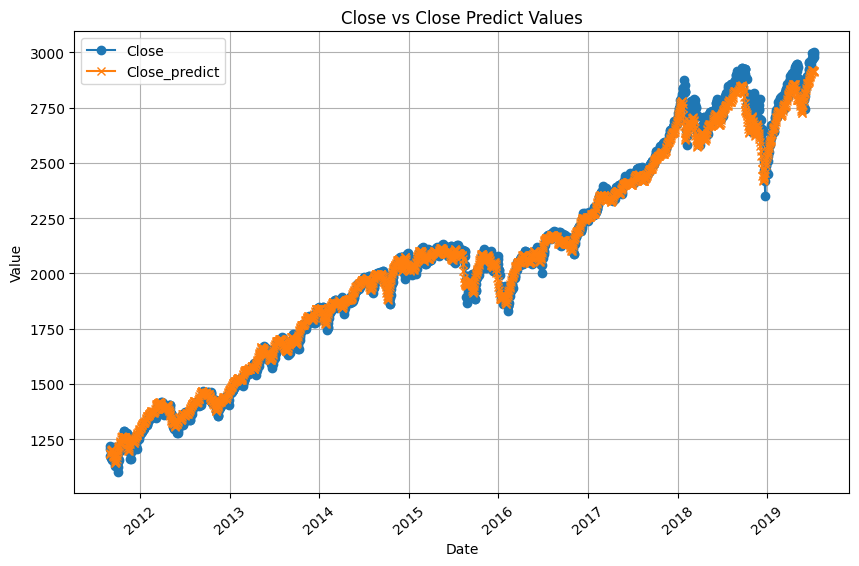

In [206]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(original['Close'], label='Close', marker='o')
plt.plot(original['Close_predict'], label='Close_predict', marker='x')
plt.title('Close vs Close Predict Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=40)
plt.legend()
plt.grid(True)
plt.show()

In [207]:
# Acesse as informações de treinamento a partir do histórico
print(history.history)

{'loss': [0.001663106377236545, 0.00011782692308770493, 0.00011720319162122905, 0.00011519323743414134, 0.000118437827040907, 0.00011612456000875682, 0.00011102330608991906, 0.00010265462333336473, 0.00010675623343558982, 9.975324792321771e-05], 'val_loss': [0.0010736570693552494, 0.0011126857716590166, 0.0011367255356162786, 0.0006910191150382161, 0.0003493695694487542, 0.00048350513679906726, 0.0004612881748471409, 0.00048426780267618597, 0.00021852571808267385, 0.0002975745592266321]}


<Axes: >

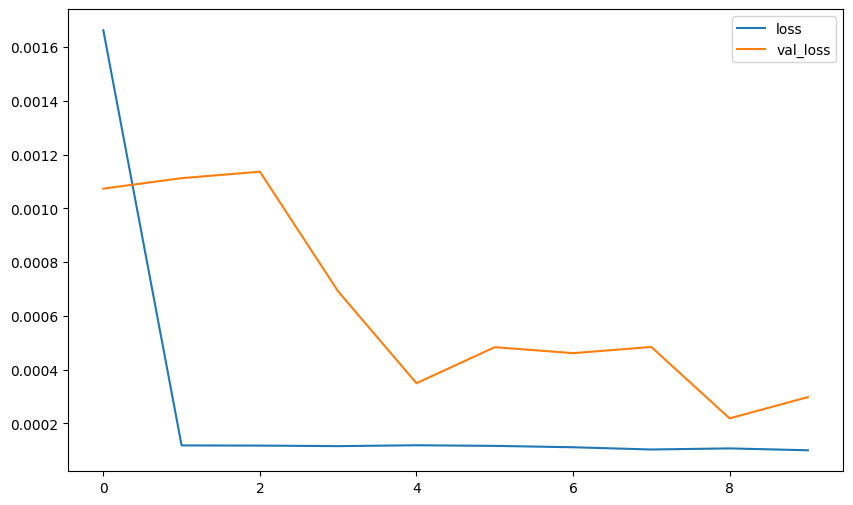

In [208]:
losses_df1 = pd.DataFrame(history.history)
losses_df1.plot(figsize = (10,6))

Codigos abaixo para testes futuros

In [209]:
predicted_close_price[:2]

array([[0.24681547],
       [0.24752307]], dtype=float32)

In [210]:
X_test_list[:2], len(X_test_list)

([[0.260655123416234, 0.266303603428527, 0.2612820608723306],
  [0.2631622083149048, 0.26572395115379965, 0.25902892295788177]],
 1977)

In [211]:
X_test.shape, list(X_test_list)[0]

((1977, 10, 3), [0.260655123416234, 0.266303603428527, 0.2612820608723306])

In [212]:
# Definir a arquitetura do autoencoder
timesteps = scaled_data.shape[0]
features = scaled_data.shape[1]

encoder = Sequential()
encoder.add(LSTM(100, activation='relu', input_shape=(timesteps, features), return_sequences=True))
encoder.add(LSTM(50, activation='relu', return_sequences=False))
encoder.add(RepeatVector(timesteps))

decoder = Sequential()
decoder.add(LSTM(50, activation='relu', return_sequences=True))
decoder.add(LSTM(100, activation='relu', return_sequences=True))
decoder.add(TimeDistributed(Dense(features)))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [213]:
autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=32)

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_20" is incompatible with the layer: expected shape=(None, 6000, 4), found shape=(None, 4)


In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
model.fit(scaled_data, df['Close'], epochs=50, batch_size=32)

In [ ]:
predicted = model.predict(scaled_data)